# Multi-Class Tabular Model for Avila Bible Identification Using Python and XGBoost
### David Lowe
### May 19, 2022

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Avila Bible Identification dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The Avila dataset includes 800 images extracted from the "Avila Bible," a giant Latin copy of the whole Bible produced during the XII century between Italy and Spain. The paleographic analysis of the manuscript has identified the presence of 12 transcribers; however, each transcriber did not transcribe the same number of pages. The prediction task is to associate each pattern to one of the 12 transcribers labeled as A, B, C, D, E, F, G, H, I, W, X, and Y. The research team normalized the data using the Z-normalization method and divided the dataset into two portions, training and test. The training set contains 10,430 samples, while the test set contains 10,437 samples.

ANALYSIS: The performance of the preliminary XGBoost model achieved an accuracy benchmark of 86.67%. After a series of tuning trials, the final model processed the training dataset with an accuracy score of 99.79%. When we processed the test dataset with the final model, the model achieved an accuracy score of 99.81%.

CONCLUSION: In this iteration, the XGBoost model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Avila Bible Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://archive-beta.ics.uci.edu/ml/datasets/avila

One source of potential performance benchmarks: https://www.sciencedirect.com/science/article/abs/pii/S0952197618300721

## Task 1 - Prepare Environment

In [1]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri May 13 02:03:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [3]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [4]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [6]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.1
VAL_SET_RATIO = 0.1

# Set the name for the class/label column
ORIGINAL_LABEL = 'Class'
CLASS_COLUMN = 'target'

# Set the number of folds for cross validation
N_FOLDS = 5

# Set default modeling scoring metric
SCORING_METRIC = 'accuracy'

# Define the directory locations and file names
TRAIN_DATASET = 'avila-tr.txt'
TEST_DATASET = 'avila-ts.txt'

In [7]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [8]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [9]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-avila-bible-identification/avila-tr.txt

In [10]:
colNames = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','Class']
df_dataset_import = pd.read_csv(TRAIN_DATASET, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

         F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   
5  0.117948 -0.220579 -3.210528 -1.623238  0.261718 -0.349509  0.257927   
6  0.389513 -0.220579 -3.210528 -2.624155  0.261718 -0.764757  0.484429   
7  0.019197 -0.040001  0.288973 -0.042597  0.261718 -1.013906  0.069175   
8  0.500607  0.140576  0.388552 -0.637358  0.261718 -0.681707  0.295677   
9 -0.252367  0.069915  0.246296  0.523550  0.261718 -1.221530  0.899684   

         F8        F9       F10 Class  
0  0.929823  0.251173  0.159345     A  
1  0.636203  0.282354  0.515587     A  
2 -0.888236 -0.123005  0.582939     A  
3  1.051693  0

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      10430 non-null  float64
 1   F2      10430 non-null  float64
 2   F3      10430 non-null  float64
 3   F4      10430 non-null  float64
 4   F5      10430 non-null  float64
 5   F6      10430 non-null  float64
 6   F7      10430 non-null  float64
 7   F8      10430 non-null  float64
 8   F9      10430 non-null  float64
 9   F10     10430 non-null  float64
 10  Class   10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 896.5+ KB


In [12]:
print(df_dataset_import.describe())

                 F1            F2            F3            F4            F5  \
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000   
mean       0.000852      0.033611     -0.000525     -0.002387      0.006370   
std        0.991431      3.920868      1.120202      1.008527      0.992053   
min       -3.498799     -2.426761     -3.210528     -5.440122     -4.922215   
25%       -0.128929     -0.259834      0.064919     -0.528002      0.172340   
50%        0.043885     -0.055704      0.217845      0.095763      0.261718   
75%        0.204355      0.203385      0.352988      0.658210      0.261718   
max       11.819916    386.000000     50.000000      3.987152      1.066121   

                 F6            F7            F8            F9           F10  
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000  
mean       0.013973      0.005605      0.010323      0.012914      0.000818  
std        1.126245      1.313754      1.003507      1

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

F1       0
F2       0
F3       0
F4       0
F5       0
F6       0
F7       0
F8       0
F9       0
F10      0
Class    0
dtype: int64
Total number of NaN in the dataframe:  0


In [14]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(ORIGINAL_LABEL).size())

Class
A    4286
B       5
C     103
D     352
E    1095
F    1961
G     446
H     519
I     831
W      44
X     522
Y     266
dtype: int64


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

         F1        F2        F3        F4        F5        F6        F7  \
0  0.266074 -0.165620  0.320980  0.483299  0.172340  0.273364  0.371178   
1  0.130292  0.870736 -3.210528  0.062493  0.261718  1.436060  1.465940   
2 -0.116585  0.069915  0.068476 -0.783147  0.261718  0.439463 -0.081827   
3  0.031541  0.297600 -3.210528 -0.583590 -0.721442 -0.307984  0.710932   
4  0.229043  0.807926 -0.052442  0.082634  0.261718  0.148790  0.635431   

         F8        F9       F10 target  
0  0.929823  0.251173  0.159345      A  
1  0.636203  0.282354  0.515587      A  
2 -0.888236 -0.123005  0.582939      A  
3  1.051693  0.594169 -0.533994      A  
4  0.051062  0.032902 -0.086652      F  


In [16]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10430 entries, 0 to 10429
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      10430 non-null  float64
 1   F2      10430 non-null  float64
 2   F3      10430 non-null  float64
 3   F4      10430 non-null  float64
 4   F5      10430 non-null  float64
 5   F6      10430 non-null  float64
 6   F7      10430 non-null  float64
 7   F8      10430 non-null  float64
 8   F9      10430 non-null  float64
 9   F10     10430 non-null  float64
 10  target  10430 non-null  object 
dtypes: float64(10), object(1)
memory usage: 896.5+ KB


In [17]:
print(df_dataset_import.describe())

                 F1            F2            F3            F4            F5  \
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000   
mean       0.000852      0.033611     -0.000525     -0.002387      0.006370   
std        0.991431      3.920868      1.120202      1.008527      0.992053   
min       -3.498799     -2.426761     -3.210528     -5.440122     -4.922215   
25%       -0.128929     -0.259834      0.064919     -0.528002      0.172340   
50%        0.043885     -0.055704      0.217845      0.095763      0.261718   
75%        0.204355      0.203385      0.352988      0.658210      0.261718   
max       11.819916    386.000000     50.000000      3.987152      1.066121   

                 F6            F7            F8            F9           F10  
count  10430.000000  10430.000000  10430.000000  10430.000000  10430.000000  
mean       0.013973      0.005605      0.010323      0.012914      0.000818  
std        1.126245      1.313754      1.003507      1

In [18]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

F1        0
F2        0
F3        0
F4        0
F5        0
F6        0
F7        0
F8        0
F9        0
F10       0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


In [19]:
# Get grouping size for the target variable
print(df_dataset_import.groupby(CLASS_COLUMN).size())

target
A    4286
B       5
C     103
D     352
E    1095
F    1961
G     446
H     519
I     831
W      44
X     522
Y     266
dtype: int64


### 1.e) Splitting Data into Sets

In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import[CLASS_COLUMN]
df_features_import = df_dataset_import.drop([CLASS_COLUMN], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (10430, 11) df_features_import.shape: (10430, 10) df_target_import.shape: (10430,)


In [21]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                                                        stratify=df_target_import)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (9387, 10) df_target_train.shape: (9387,)
df_features_test.shape: (1043, 10) df_target_test.shape: (1043,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

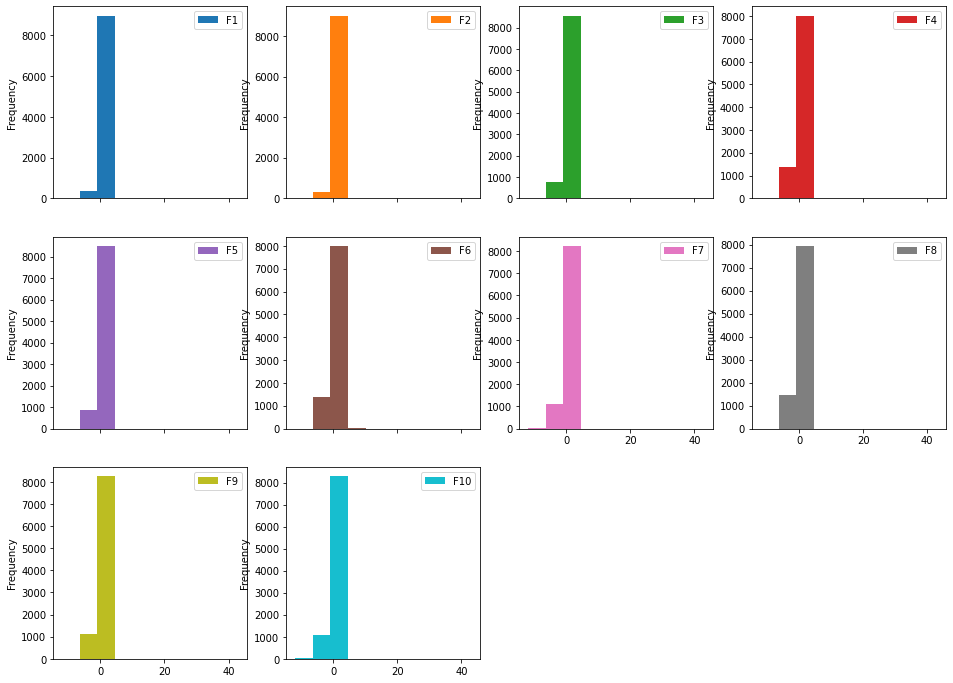

In [25]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

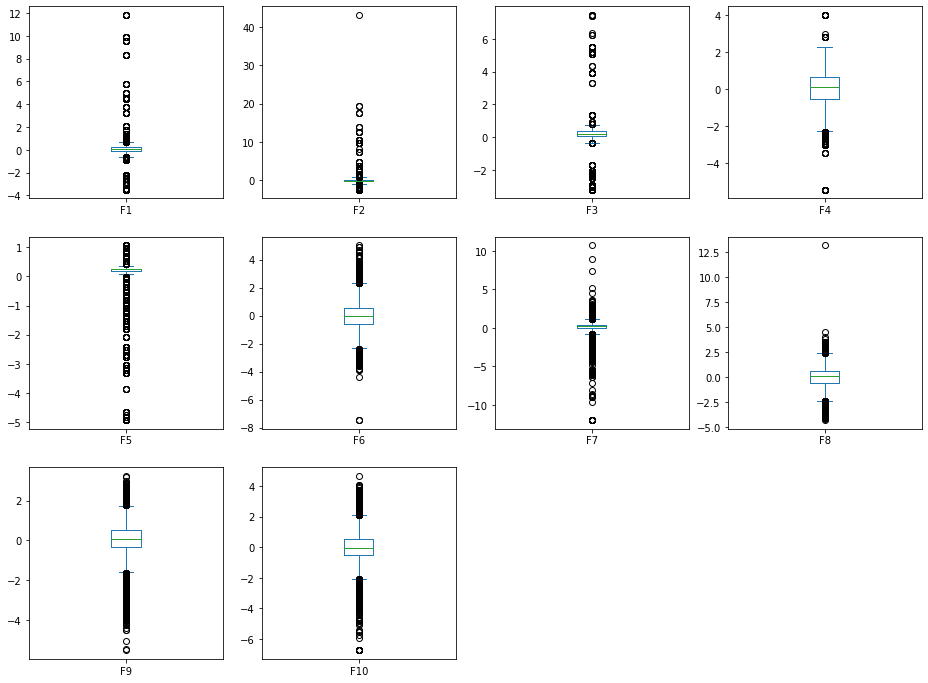

In [26]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

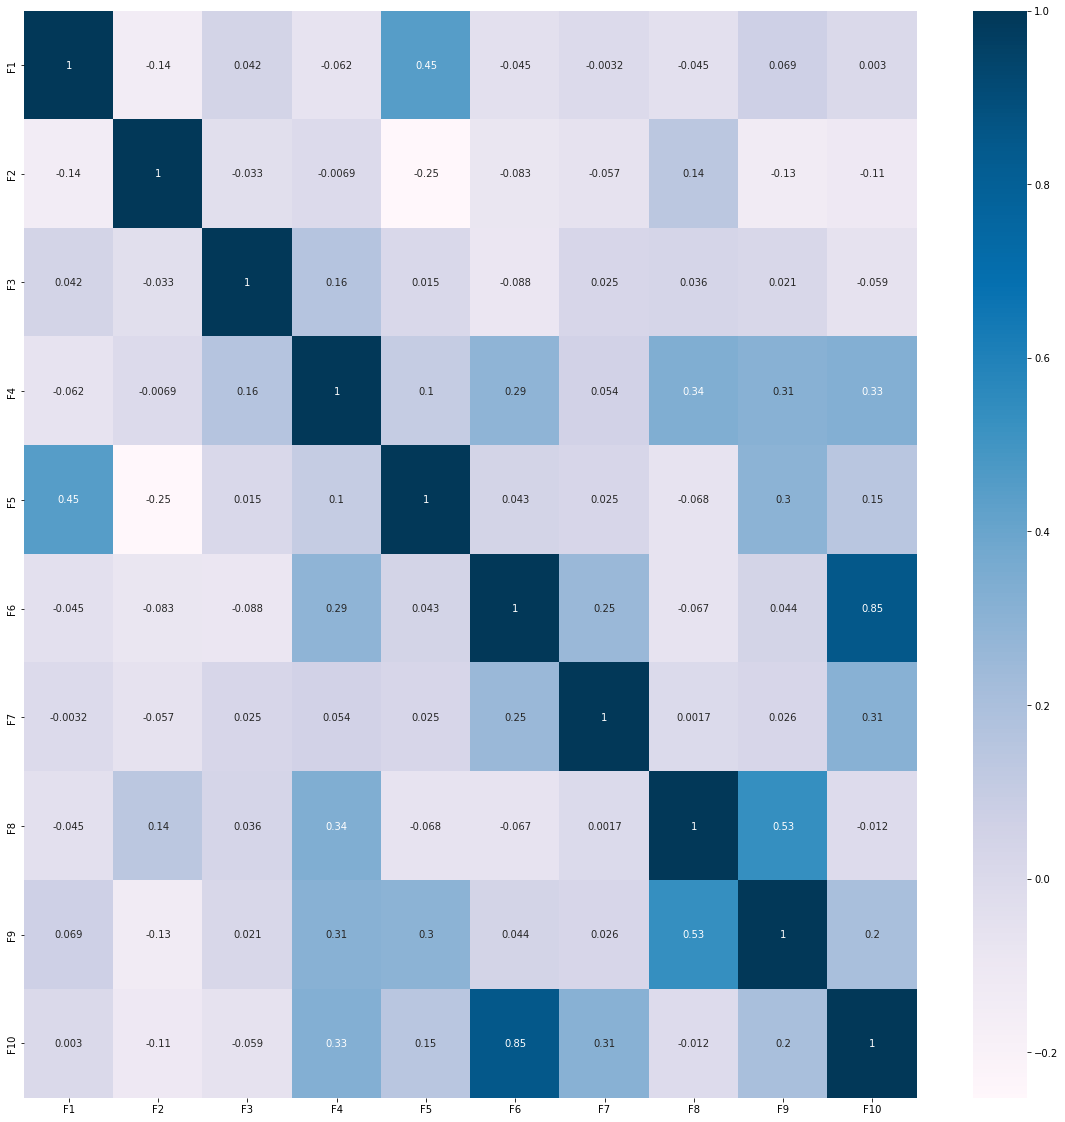

In [27]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [29]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [30]:
# Not applicable for this iteration of the project

### 3.b) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [33]:
# Finalize the training dataset for the modeling activities
array_features_train = df_features_train.to_numpy()
label_encoder = preprocessing.LabelEncoder()
array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (9387, 10) array_target_train.shape: (9387,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []

In [37]:
train_models.append(('XGB', XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softmax', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')))

In [38]:
# Generate model in turn
for name, model in train_models:
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    start_time_module = datetime.now()
    kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
    cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
    train_results.append(cv_results)
    train_model_names.append(name)
    train_metrics.append(cv_results.mean())
    print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
    print(model)
    print ('Model training time:', (datetime.now() - start_time_module), '\n')
    if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:', np.mean(train_metrics))
print ('Total training time for all models:', (datetime.now() - start_time_training))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


XGB: 0.866730 (0.005975)
XGBClassifier(eval_metric='mlogloss', objective='multi:softmax',
              random_state=888, tree_method='gpu_hist',
              use_label_encoder=False)
Model training time: 0:00:13.716296 

Average metrics (accuracy) from all models: 0.8667296452828733
Total training time for all models: 0:00:13.767793


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.7s finished


### 4.b) Algorithm Tuning

In [39]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [40]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100, 501, 100),
                  max_depth=np.array([3, 6, 9]),
                  min_child_weight=np.array([1, 2, 3]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:', (datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #1 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best: 0.997017 using {'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 400}
0.866730 (0.005975) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.941514 (0.004631) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.972195 (0.004540) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.986896 (0.002068) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.993608 (0.001348) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.863960 (0.004267) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.940556 (0.004537) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.971450 (0.003511) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.986044 (0.002062) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.992436 (0.001560) with: {'max_depth': 3, 'min_child_weight': 2, 'n_esti

In [41]:
BEST_MAX_DEPTH = grid_result1.best_params_['max_depth']
BEST_MIN_CHILD_WEIGHT = grid_result1.best_params_['min_child_weight']
BEST_N_ESTIMATORS = grid_result1.best_params_['n_estimators']
print('Best max_depth parameter:', BEST_MAX_DEPTH)
print('Best min_child_weight parameter:', BEST_MIN_CHILD_WEIGHT)
print('Best n_estimators parameter:', BEST_N_ESTIMATORS)

Best max_depth parameter: 6
Best min_child_weight parameter: 1
Best n_estimators parameter: 400


In [42]:
# Tuning XGBoost subsample and colsample_bytree parameters
start_time_Module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            random_state=RNG_SEED, n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7, 0.8, 0.9, 1.0]),
                  colsample_bytree=np.array([0.7, 0.8, 0.9, 1.0]))

kfold = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - start_time_Module))
if NOTIFY_STATUS: status_notify("Algorithm tuning iteration #2 completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Best: 0.997976 using {'colsample_bytree': 0.7, 'subsample': 0.8}
0.997763 (0.000622) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.997976 (0.000522) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.997976 (0.001234) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.997976 (0.001234) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.997869 (0.000674) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.997443 (0.001033) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.997550 (0.000640) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.997550 (0.001196) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.996910 (0.001034) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.996697 (0.000853) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.996910 (0.001033) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.996804 (0.001011) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.996697 (0.000399) with: {'colsample_bytree': 1.0, 'subsample': 0.7}
0.996484 (0.000723) with:

In [43]:
BEST_COLSAMPLE_BYTREE = grid_result2.best_params_['colsample_bytree']
BEST_SUBSAMPLE = grid_result2.best_params_['subsample']
print('Best colsample_bytree parameter:', BEST_COLSAMPLE_BYTREE)
print('Best subsample parameter:', BEST_SUBSAMPLE)

Best colsample_bytree parameter: 0.7
Best subsample parameter: 0.8


### 4.c) Compare Algorithms After Tuning

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


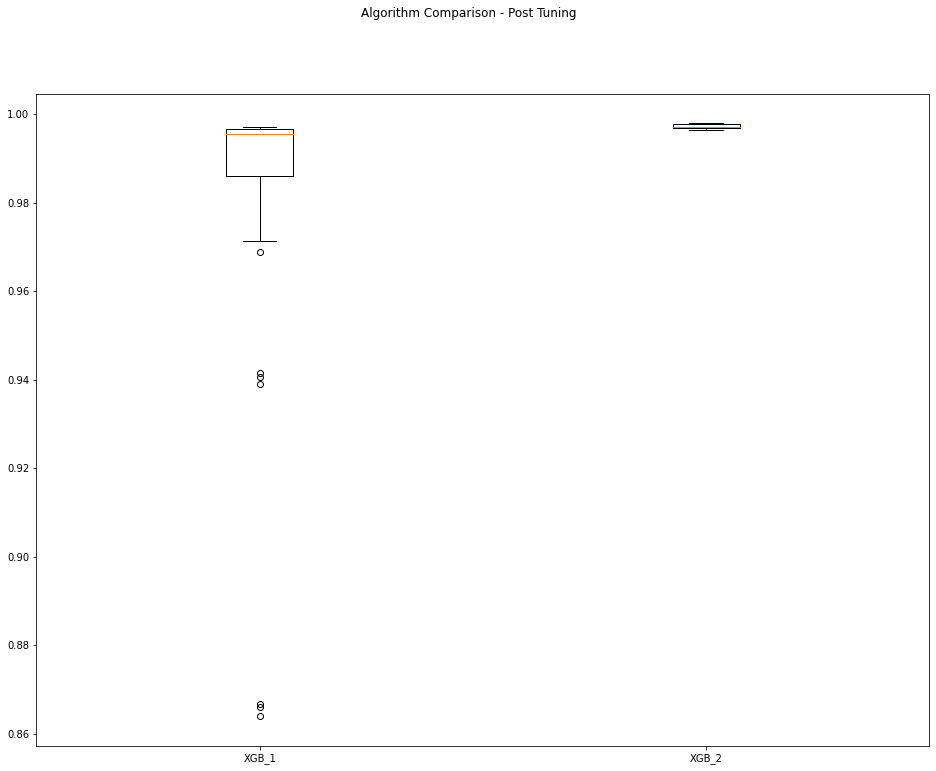

In [44]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [47]:
final_model = XGBClassifier(n_estimators=BEST_N_ESTIMATORS, max_depth=BEST_MAX_DEPTH, min_child_weight=BEST_MIN_CHILD_WEIGHT,
                            colsample_bytree=BEST_COLSAMPLE_BYTREE, subsample=BEST_SUBSAMPLE, random_state=RNG_SEED,
                            n_jobs=N_JOBS, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', tree_method='gpu_hist')
final_model.fit(array_features_train, array_target_train)
print(final_model)

XGBClassifier(colsample_bytree=0.7, eval_metric='mlogloss', max_depth=6,
              n_estimators=400, objective='multi:softprob', random_state=888,
              subsample=0.8, tree_method='gpu_hist', use_label_encoder=False)


### 5.b) Load Test Dataset and Make Predictions

In [48]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/ucirvine-avila-bible-identification/avila-ts.txt

In [49]:
df_dataset_test = pd.read_csv(TEST_DATASET, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_test.head())

         F1        F2        F3        F4        F5        F6        F7  \
0 -3.498799  0.250492  0.232070  1.224178 -4.922215  1.145386  0.182426   
1  0.204355 -0.354049  0.320980  0.410166 -0.989576 -2.218127  0.220177   
2  0.759828 -1.304042 -0.023991 -0.973663 -0.006417 -0.349509 -0.421580   
3 -0.005490  0.360409  0.281860 -0.213479 -1.168333 -1.013906 -0.346080   
4  0.080916  0.101320  0.104040  0.140490  0.261718  0.480988  0.710932   

         F8        F9       F10 Class  
0 -0.165983 -0.123005  1.087144     W  
1  0.181844  2.090879 -2.009758     A  
2 -0.450127  0.469443  0.060952     I  
3  1.176165  0.968347 -0.627999     E  
4 -0.253430 -0.497183  0.155681     A  


In [50]:
# Standardize the class column to the name of targetVar if required
df_dataset_test = df_dataset_test.rename(columns={ORIGINAL_LABEL: CLASS_COLUMN})

# Take a peek at the dataframe after cleaning
print(df_dataset_test.head())

         F1        F2        F3        F4        F5        F6        F7  \
0 -3.498799  0.250492  0.232070  1.224178 -4.922215  1.145386  0.182426   
1  0.204355 -0.354049  0.320980  0.410166 -0.989576 -2.218127  0.220177   
2  0.759828 -1.304042 -0.023991 -0.973663 -0.006417 -0.349509 -0.421580   
3 -0.005490  0.360409  0.281860 -0.213479 -1.168333 -1.013906 -0.346080   
4  0.080916  0.101320  0.104040  0.140490  0.261718  0.480988  0.710932   

         F8        F9       F10 target  
0 -0.165983 -0.123005  1.087144      W  
1  0.181844  2.090879 -2.009758      A  
2 -0.450127  0.469443  0.060952      I  
3  1.176165  0.968347 -0.627999      E  
4 -0.253430 -0.497183  0.155681      A  


In [51]:
# We create attribute-only and target-only datasets
df_target_test = df_dataset_test[CLASS_COLUMN]
df_features_test = df_dataset_test.drop([CLASS_COLUMN], axis=1)

print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_test.shape: (10437, 10) df_target_test.shape: (10437,)


In [52]:
# Finalize the test dataset for the testing activities
array_features_test = df_features_test.to_numpy()
array_target_test = label_encoder.transform(df_target_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (10437, 10) to array_features_test.shape: (10437, 10)


In [53]:
# Make batched predictions
test_predictions =  final_model.predict(array_features_test)
print(test_predictions)

[9 0 8 ... 0 5 7]


In [54]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions),'\n')
print(confusion_matrix(array_target_test, test_predictions),'\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 0.9981795535115454 

[[4286    0    0    0    0    0    0    0    0    0    0    0]
 [   0    5    0    0    0    0    0    0    0    0    0    0]
 [   0    0  103    0    0    0    0    0    0    0    0    0]
 [   0    0    0  353    0    0    0    0    0    0    0    0]
 [   2    0    0    0 1093    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1962    0    0    0    0    0    0]
 [   0    0    0    0    0    0  447    0    0    0    0    0]
 [   0    0    3    0    0    0    0  517    0    0    0    0]
 [   2    0    0    0    0    0    0    0  830    0    0    0]
 [   0    0    0    0    0    0    0    0    0   45    0    0]
 [   1    0    0    0    4    0    0    0    0    0  511    6]
 [   1    0    0    0    0    0    0    0    0    0    0  266]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4286
           1       1.00      1.00      1.00         5
           2       0.97      1.00      0.

In [55]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [56]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:36:14.060550
